# Ethereum smart contract usage

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BLOCK_SAMPLE_SIZE = 16611
BLOCK_PRINT_INTERVAL = 1500
TX_PRINT_INTERVAL = 25000

SAMPLE_FILE = 'sample.json'
SAMPLE_TRACE_CACHE_FILE = 'sample-trace-cache.json'
SAMPLE_SUMMARIES_FILE = 'sample-tx-summaries.json'
FULL_TRACE_CACHE_FILE = 'last50k-trace-cache.json'

In [2]:
bh = pd.read_csv('eth-headers-9250k.csv')
bh

,block_num,timestamp,num_tx,gas_used,gas_limit,difficulty,block_size
0,1,1438269988,0,0,5000,17171480576,537
1,2,1438270017,0,0,5000,17163096064,544
2,3,1438270048,0,0,5000,17154715646,1079
3,4,1438270077,0,0,5000,17146339321,1079
4,5,1438270083,0,0,5000,17154711556,537
...,...,...,...,...,...,...,...
9249995,9249996,1578619226,146,9188792,9469072,2036276480074368,35406
9249996,9249997,1578619240,124,7443450,9473286,2036276480074369,20499
9249997,9249998,1578619245,102,9312474,9482536,2037270755699406,30752
9249998,9249999,1578619260,113,7485046,9473277,2037270755699407,23964


In [3]:
total_blocks = len(bh)
total_tx = bh['num_tx'].sum()
total_gas_used = bh['gas_used'].sum()
total_size = bh['block_size'].sum()

(total_blocks, total_tx, total_gas_used, total_size / (1024**3))

(9250000, 616860313, 35708236435579, 110.04836712498218)

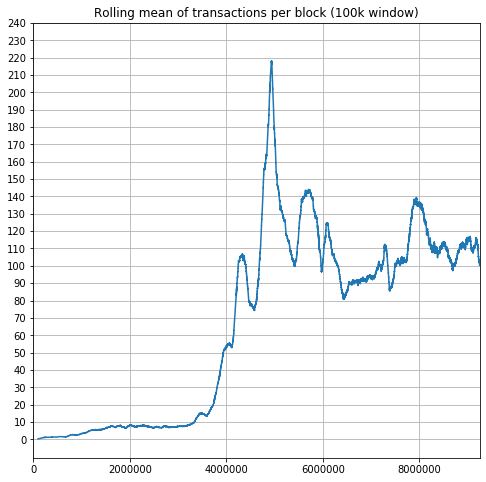

In [4]:
bh['num_tx'].rolling(window=100000).mean().plot(title='Rolling mean of transactions per block (100k window)', yticks=list(range(0, 250, 10)), grid=True, figsize=(8,8))
plt.savefig('mean_tx_per_block.svg', bbox_inches='tight')

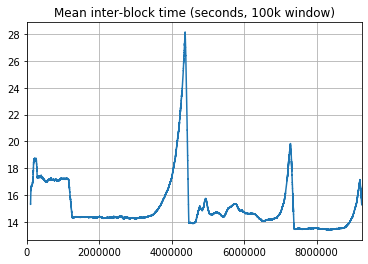

In [5]:
bh['timestamp'].diff().rolling(window=100000).mean().plot(title='Mean inter-block time (seconds, 100k window)', grid=True)
plt.savefig('inter_block_time.svg', bbox_inches='tight')

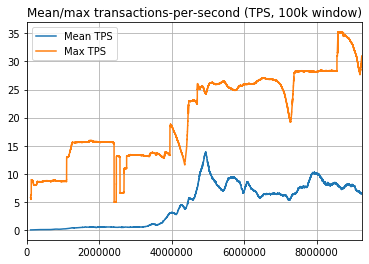

In [6]:
tps_mean = bh['num_tx'].rolling(window=100000).mean() / bh['timestamp'].diff().rolling(window=100000).mean()
tps_max = bh['num_tx'].rolling(window=100000).max() / bh['timestamp'].diff().rolling(window=100000).mean()
tps_mean.name = 'Mean TPS'
tps_max.name = 'Max TPS'
tps_mean.plot(title='Mean/max transactions-per-second (TPS, 100k window)', legend=True)
tps_max.plot(grid=True, legend=True)
plt.savefig('tps.svg', bbox_inches='tight')

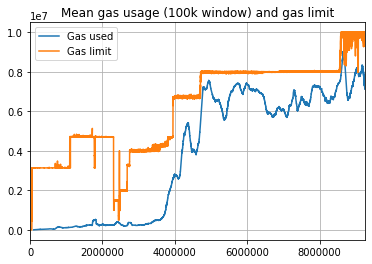

In [7]:
gas_used = bh['gas_used'].rolling(window=100000).mean()
gas_limit = bh['gas_limit']
gas_used.name = 'Gas used'
gas_limit.name = 'Gas limit'
gas_used.plot(legend=True), gas_limit.plot(legend=True, title='Mean gas usage (100k window) and gas limit', grid=True)
plt.savefig('gas.svg', bbox_inches='tight')

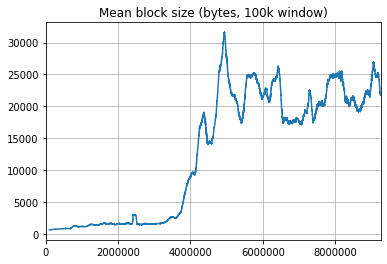

In [8]:
bh['block_size'].rolling(window=100000).mean().plot(title='Mean block size (bytes, 100k window)', grid=True)

## What do Ethereum transactions look like?

In [9]:
# pip install jsonrpc-requests
from jsonrpc_requests import Server
# Parity server synced with --tracing=on and allowing JSONRPC connections
JSONRPC_ENDPOINT = "http://172.23.86.218:8545"
rpc = Server(JSONRPC_ENDPOINT)

## Generic helper functions
def make_hex(block_num):
    if isinstance(block_num, np.int64):
        block_num = int(block_num)
        
    if isinstance(block_num, int):
        block_num = hex(block_num)
    elif isinstance(block_num, str):
        if not int(block_num, 16):
            block_num = hex(int(block_num))
    else:
        raise ValueError('arg {} is not convertible to hex number'.format(block_num))
    return block_num

## RPC methods
def eth_getBlockByNumber(block_num, full_transactions=False):
    block_num = make_hex(block_num)
    return rpc.eth_getBlockByNumber(block_num, full_transactions)

def eth_getBlockTransactionCountByNumber(block_num):
    block_num = make_hex(block_num)
    return int(rpc.eth_getBlockTransactionCountByNumber(block_num), 16)

def eth_getTransactionReceipt(tx_hash):
    return rpc.eth_getTransactionReceipt(tx_hash)

def trace_transaction(tx_hash):
    return rpc.trace_transaction(tx_hash)


## Helpers for working with transaction ordinals
cum_tx = bh['num_tx'].cumsum()

# Returns the block number of the n-th transaction in the chain
def tx_block(tx_ordinal):
    block_idx = cum_tx.searchsorted(tx_ordinal)
    block_num = block_idx + 1
    return block_num

# Returns the block number and index of the n-th transaction in the chain
def tx_pos(tx_ordinal):
    block_idx = cum_tx.searchsorted(tx_ordinal)
    block_num = block_idx + 1
    block_txs = eth_getBlockTransactionCountByNumber(block_num)
    end = int(cum_tx[block_idx])
    start = end - block_txs
    # transaction indices are zero based, hence the -1
    tx_idx = tx_ordinal - start - 1
    return (block_num, tx_idx)
    
# Returns the hash of the n-th transaction in the chain
# Duplicates `tx_pos` to only make one RPC call
def nth_tx(tx_ordinal):
    block_idx = cum_tx.searchsorted(tx_ordinal)
    block_num = block_idx + 1
    block = eth_getBlockByNumber(block_num)
    
    block_txs = len(block['transactions'])
    end = int(cum_tx[block_idx])
    start = end - block_txs
    # transaction indices are zero based, hence the -1
    tx_idx = tx_ordinal - start - 1

    return block['transactions'][tx_idx]

## Let's sample some blocks!

In [10]:
import random, os, json
from time import gmtime, strftime

def get_tx_hashes(block_list):
    block_txs = {}
    txs = []
    proc_blocks = 0
    for block_num in block_list:
        bl = eth_getBlockByNumber(block_num)
        txs.extend(bl['transactions'])
        # Need to be careful with saving to JSON
        # integers cannot be dict keys, so they get converted to string
        block_txs[str(block_num)] = bl['transactions']
        
        if proc_blocks % BLOCK_PRINT_INTERVAL == 0:
            time_str = strftime("%d %b %Y %H:%M:%S +0000", gmtime())
            percent = proc_blocks / len(block_list) * 100
            print("[{}] Processed {} blocks total ({:.2f}% done)".format(time_str, proc_blocks, percent))
        proc_blocks += 1
    return (txs, block_txs)

block_range = range(1, total_blocks + 1)
block_sample = []
tx_sample = []
block_txs = {}

# Import sample from disk if saved file exists
if os.path.exists(SAMPLE_FILE):
    with open(SAMPLE_FILE, 'r') as f:
        sample = json.load(f)
        block_sample = sample['block_sample']
        tx_sample = sample['tx_sample']
        block_txs = sample['block_txs']
        print('Loaded sample of {} blocks and {} transactions from disk.'.format(len(block_sample), len(tx_sample)))
else:
    # Generate a sample
    block_sample = sorted(random.sample(block_range, BLOCK_SAMPLE_SIZE))
    tx_sample, block_txs = get_tx_hashes(block_sample)
    
    # And save it to disk
    with open(SAMPLE_FILE, 'w') as f:
        sample = {'block_sample': block_sample, 'tx_sample': tx_sample, 'blocks_txs': block_txs}
        json.dump(sample, f)
        print('Saved sample of {} blocks and {} transactions to disk.'.format(len(block_sample), len(tx_sample)))

Loaded sample of 16611 blocks and 1099138 transactions from disk.


Note the massive difference sampling transaction makes relative to sampling blocks. Only ~6% of transactions are in blocks < 4 million.

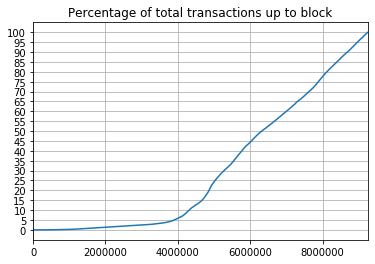

In [11]:
perc_tx = cum_tx / total_tx * 100
perc_tx.plot(title='Percentage of total transactions up to block', grid=True, yticks=list(range(0, 101, 5)))

## What do these transactions do?

In [12]:
trace_cache = {}

In [13]:
# "Manually" populate trace cache
def populate_trace_cache(tx_list):
    proc_txs = 0
    for h in tx_list:
        if h not in trace_cache:
            trace = trace_transaction(h)
            trace_cache[h] = trace
            
        if proc_txs % TX_PRINT_INTERVAL == 0:
            time_str = strftime("%d %b %Y %H:%M:%S +0000", gmtime())
            percent = proc_txs / len(tx_list) * 100
            print("[{}] Processed {} transactions total ({:.2f}% done)".format(time_str, proc_txs, percent))
        proc_txs += 1

if not os.path.exists(SAMPLE_TRACE_CACHE_FILE):
    populate_trace_cache(tx_sample)
    with open(SAMPLE_TRACE_CACHE_FILE, 'w') as f:
        json.dump(trace_cache, f)
        print('Saved traces of {} transactions from disk.'.format(len(tx_sample)))
else:
    with open(SAMPLE_TRACE_CACHE_FILE, 'r') as f:
        trace_cache = json.load(f)
        assert(len(trace_cache) == len(tx_sample))
        print('Loaded traces of {} transactions from disk.'.format(len(tx_sample)))

Loaded traces of 1099138 transactions from disk.


In [14]:
def tx_stats(h, get_receipts=False):
    trace = trace_cache.get(h)
    if trace is None:
        trace = trace_transaction(h)
        trace_cache[h] = trace

    is_transfer = False
    is_single_call = False
    is_erc20_transfer = False
    erc20_contract = None
    num_actions = len(trace)
    touched_addresses = set()
    
    has_proxied = False
    is_proxied_single_call = False
    is_proxied_erc20_transfer = False
    is_proxied_multi_call = False
        
    # Sadly, the JSON-RPC API is not type-safe, so we need some hacky checks
    for index, action in enumerate(trace):
        action = action['action']

        if 'callType' not in action:
            # Contract creation
            if 'init' in action:
                pass
            # Suicide
            if 'refundAddress' in action:
                pass
        # call, callcode, or delegatecall
        elif 'callType' in action:
            touched_addresses.add(action['from'])
            touched_addresses.add(action['to'])

            if action['callType'] == 'delegatecall':
                has_proxied = True
            if num_actions == 1 and index == 0 and action['callType'] == 'call' and action['input'] == '0x':
                is_transfer = True
            elif num_actions == 1:
                is_single_call = True
                if action['callType'] == 'call' and '0xa9059cbb' in action['input']:
                    is_erc20_transfer = True
                    erc20_contract = action['to']
            elif has_proxied is True:
                if num_actions == 2:
                    is_proxied_single_call = True
                    if '0xa9059cbb' in action['input']:
                        is_proxied_erc20_transfer = True
                else:
                    is_proxied_multi_call = True
    
    tx = {
        'hash': h,
        'is_transfer': is_transfer,
        'is_erc20_transfer': is_erc20_transfer,
        'is_single_call': is_single_call,
        'num_actions': num_actions,
        'touched_addresses': list(touched_addresses),
        'is_proxied_single_call': is_proxied_single_call,
        'is_proxied_erc20_transfer': is_proxied_erc20_transfer,
        'is_proxied_multi_call': is_proxied_multi_call,
    }
    
    if get_receipts:
        receipt = eth_getTransactionReceipt(h)
        tx['receipt'] = receipt

    return tx

In [15]:
tx_summary = {h: tx_stats(h) for h in tx_sample}

In [16]:
transfers = set(filter(lambda tx: tx_summary[tx]['is_transfer'], tx_sample))
erc20_transfers = set(filter(lambda tx: tx_summary[tx]['is_erc20_transfer'], tx_sample))
single_call = set(filter(lambda tx: tx_summary[tx]['is_single_call'], tx_sample))
multi_call = set(filter(lambda tx: tx_summary[tx]['num_actions'] > 1, tx_sample))
proxied_single_call = set(filter(lambda tx: tx_summary[tx]['is_proxied_single_call'], tx_sample))
proxied_multi_call = set(filter(lambda tx: tx_summary[tx]['is_proxied_multi_call'], tx_sample))

First of all, let us look at how many of these transactions are user-to-user ETH transfers, how many call a single contract, and how many make multiple calls. (Note that transfers are `call`s in the EVM, so a transaction that calls a contract which sends some ETH makes two `call`s.)

In [17]:
distr = (len(transfers) / len(tx_sample), len(single_call) / len(tx_sample), len(multi_call) / len(tx_sample))
(distr, sum(distr))
# Sanity check: the sum should be close to 1
# (contract creation & suicide are a small portion of transactions)

((0.4718533978444927, 0.368516965112661, 0.15435550404043896),
 0.9947258669975927)

In [18]:
len(erc20_transfers) / len(single_call)

0.7620176224722319

How has this distribution changed over time?

In [19]:
tx_distr = {}
bucket_size = 100 * 1000 # blocks

for block_num in block_sample:
    bucket = int(block_num / bucket_size) * bucket_size
    if bucket not in tx_distr:
        tx_distr[bucket] = {'transfer': 0, 'single_call': 0, 'multi_call': 0, 'other': 0, 'total': 0}
    
    for tx in block_txs[str(block_num)]:
        if tx in transfers:
            tx_distr[bucket]['transfer'] += 1
        elif tx in single_call:
            tx_distr[bucket]['single_call'] += 1
        elif tx in multi_call:
            tx_distr[bucket]['multi_call'] += 1
        else:
            tx_distr[bucket]['other'] += 1

        tx_distr[bucket]['total'] += 1

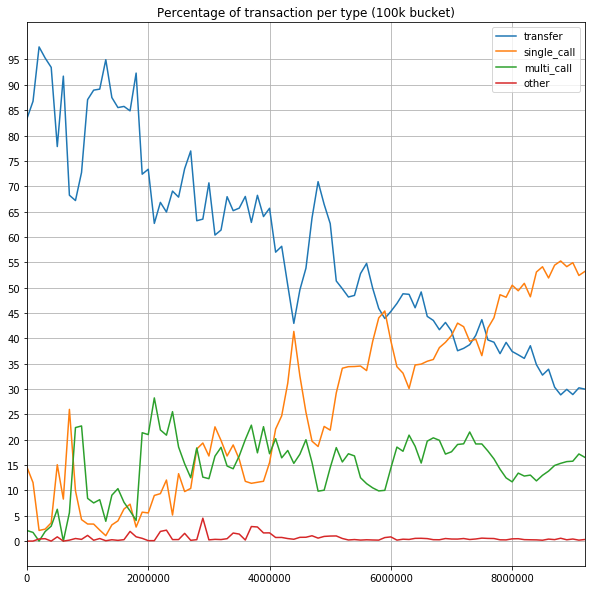

In [20]:
b_dist = pd.DataFrame.from_dict(tx_distr, orient='index')
# Normalize
b_dist['transfer'] = b_dist['transfer'] / b_dist['total'] * 100
b_dist['single_call'] = b_dist['single_call'] / b_dist['total'] * 100
b_dist['multi_call'] = b_dist['multi_call'] / b_dist['total'] * 100
b_dist['other'] = b_dist['other'] / b_dist['total'] * 100
del b_dist['total']
b_dist
# Plot
# b_dist.rolling(window=3).mean().plot(title='Percentage (mean) of transaction per type (100k window)', figsize=(10, 10), yticks=list(range(0, 100, 5)), grid=True)
b_dist.plot(title='Percentage of transaction per type (100k bucket)', figsize=(10, 10), yticks=list(range(0, 100, 5)), grid=True)
plt.savefig('tx_breakdown.svg', bbox_inches='tight')

## Gas usage

In [21]:
tx_summary = {}

In [22]:
# Import summaries from disk if saved file exists
if os.path.exists(SAMPLE_SUMMARIES_FILE):
    with open(SAMPLE_SUMMARIES_FILE, 'r') as f:
        tx_summary = json.load(f)
        print('Loaded {} transactions summaries from disk.'.format(len(tx_summary)))
else:
    tx_summary = {h: tx_stats(h, get_receipts=True) for h in tx_sample}
    
    # And save it to disk
    with open(SAMPLE_SUMMARIES_FILE, 'w') as f:
        json.dump(tx_summary, f)
        print('Saved {} transactions summaries to disk.'.format(len(tx_summary)))

Loaded 1099138 transactions summaries from disk.


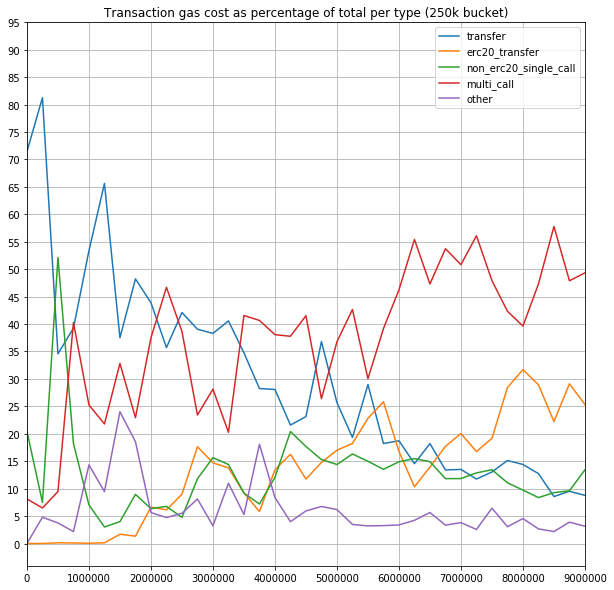

In [23]:
gas_distr = {}
bucket_size = 250 * 1000 # blocks

for block_num in block_sample:
    bucket = int(block_num / bucket_size) * bucket_size
    if bucket not in gas_distr:
        gas_distr[bucket] = {'transfer': 0, 'erc20_transfer': 0, 'non_erc20_single_call': 0, 'multi_call': 0, 'other': 0, 'total': 0}
    
    for tx in block_txs[str(block_num)]:
        gas_used = int(tx_summary[tx]['receipt']['gasUsed'], 16)
        
        if tx in transfers:
            gas_distr[bucket]['transfer'] += gas_used
        elif tx in erc20_transfers:
            gas_distr[bucket]['erc20_transfer'] += gas_used
        elif tx in single_call:
            gas_distr[bucket]['non_erc20_single_call'] += gas_used
        elif tx in multi_call:
            gas_distr[bucket]['multi_call'] += gas_used
        else:
            gas_distr[bucket]['other'] += gas_used

        gas_distr[bucket]['total'] += gas_used
        
    b_dist = pd.DataFrame.from_dict(gas_distr, orient='index')
# Normalize
b_dist['transfer'] = b_dist['transfer'] / b_dist['total'] * 100
b_dist['erc20_transfer'] = b_dist['erc20_transfer'] / b_dist['total'] * 100
b_dist['non_erc20_single_call'] = b_dist['non_erc20_single_call'] / b_dist['total'] * 100
b_dist['multi_call'] = b_dist['multi_call'] / b_dist['total'] * 100
b_dist['other'] = b_dist['other'] / b_dist['total'] * 100
del b_dist['total']
b_dist
# Plot
b_dist.plot(title='Transaction gas cost as percentage of total per type (250k bucket)', figsize=(10, 10), yticks=list(range(0, 100, 5)), grid=True)
plt.savefig('gas_breakdown.svg', bbox_inches='tight')

## What do the single call transactions look like?

In [24]:
len(erc20_transfers) / len(single_call)

0.7620176224722319

75% are ERC 20 token transfers. If we plot the distribution by treating at ERC 20 token transfers separately from the other single call transactions, the situation looks like this:

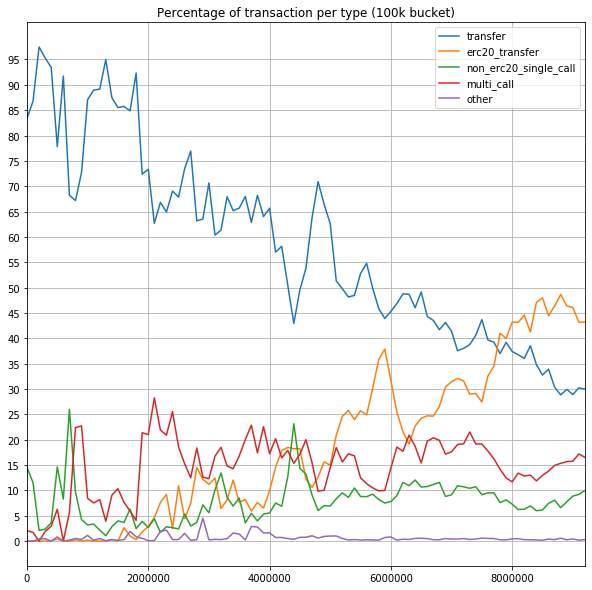

In [25]:
tx_distr = {}
bucket_size = 100 * 1000 # blocks

for block_num in block_sample:
    bucket = int(block_num / bucket_size) * bucket_size
    if bucket not in tx_distr:
        tx_distr[bucket] = {'transfer': 0, 'erc20_transfer': 0, 'non_erc20_single_call': 0, 'multi_call': 0, 'other': 0, 'total': 0}
    
    for tx in block_txs[str(block_num)]:     
        if tx in transfers:
            tx_distr[bucket]['transfer'] += 1
        elif tx in erc20_transfers:
            tx_distr[bucket]['erc20_transfer'] += 1
        elif tx in single_call:
            tx_distr[bucket]['non_erc20_single_call'] += 1
        elif tx in multi_call:
            tx_distr[bucket]['multi_call'] += 1
        else:
            tx_distr[bucket]['other'] += 1

        tx_distr[bucket]['total'] += 1

b_dist = pd.DataFrame.from_dict(tx_distr, orient='index')
# Normalize
b_dist['transfer'] = b_dist['transfer'] / b_dist['total'] * 100
b_dist['erc20_transfer'] = b_dist['erc20_transfer'] / b_dist['total'] * 100
b_dist['non_erc20_single_call'] = b_dist['non_erc20_single_call'] / b_dist['total'] * 100
b_dist['multi_call'] = b_dist['multi_call'] / b_dist['total'] * 100
b_dist['other'] = b_dist['other'] / b_dist['total'] * 100
del b_dist['total']
# Plot
b_dist.plot(title='Percentage of transaction per type (100k bucket)', figsize=(10, 10), yticks=list(range(0, 100, 5)), grid=True)
plt.savefig('tx_erc20_breakdown.svg', bbox_inches='tight')

* What are the most popular ERC 20 tokens?

## What do the multi-call transactions look like?

In [26]:
mc_touched = pd.Series(list(map(lambda tx: len(tx_stats(tx)['touched_addresses']), multi_call))).value_counts()
mc_touched = mc_touched / len(multi_call) * 100
mc_touched[:4].sum()

87.06279692086432

87% percent of them touch fewer than 5 addresses.

## Usage of proxy contracts

In [27]:
len(proxied_single_call) / len(tx_sample) * 100, len(proxied_multi_call) / len(tx_sample) * 100

(0.4544470303092059, 3.0632186313274588)

# Last 50k blocks

In [28]:
trace_cache = {}

In [29]:
last_50k = []
block_txs = {}

if not os.path.exists(FULL_TRACE_CACHE_FILE):
    blocks = range(9200000, 9201000 + 1)
    last_50k, block_txs = get_tx_hashes(blocks)
    populate_trace_cache(last_50k)
    with open(FULL_TRACE_CACHE_FILE, 'w') as f:
        json.dump(trace_cache, f)
        print('Saved traces of {} transactions from disk.'.format(len(trace_cache)))
else:
    with open(FULL_TRACE_CACHE_FILE, 'r') as f:
        trace_cache = json.load(f)
        print('Loaded traces of {} transactions from disk.'.format(len(trace_cache)))
        last_50k = trace_cache.keys()
        for k in trace_cache:
            block = str(trace_cache[k][0]['blockNumber'])
            if block not in block_txs:
                block_txs[block] = []
            block_txs[block].append(k)
        print('({} non-empty blocks)'.format(len(block_txs)))

(len(last_50k), len(trace_cache))

Loaded traces of 4549014 transactions from disk.
(48278 non-empty blocks)


(4549014, 4549014)

In [30]:
tx_summary = {h: tx_stats(h) for h in last_50k}

transfers = set(filter(lambda tx: tx_summary[tx]['is_transfer'], last_50k))
erc20_transfers = set(filter(lambda tx: tx_summary[tx]['is_erc20_transfer'], last_50k))
single_call = set(filter(lambda tx:tx_summary[tx]['is_single_call'], last_50k))
multi_call = set(filter(lambda tx: tx_summary[tx]['num_actions'] > 1, last_50k))
proxied_single_call = set(filter(lambda tx: tx_summary[tx]['is_proxied_single_call'], last_50k))
proxied_erc20_transfers = set(filter(lambda tx: tx_summary[tx]['is_proxied_erc20_transfer'], last_50k))
proxied_multi_call = set(filter(lambda tx: tx_summary[tx]['is_proxied_multi_call'], last_50k))

In [31]:
distr = (len(transfers) / len(last_50k), len(single_call) / len(last_50k), len(multi_call) / len(last_50k))
(distr, len(erc20_transfers) / len(single_call))

((0.30713468896776314, 0.5159867610871279, 0.17459607730378496),
 0.8191780016538637)

In [32]:
len(proxied_single_call) / len(multi_call), len(proxied_multi_call) / len(multi_call)

(0.07147965350523772, 0.3349755741337631)

In [33]:
len(proxied_erc20_transfers) , len(proxied_single_call)

(45552, 56772)

In [34]:
len(erc20_transfers) , len(single_call)

(1922800, 2347231)

In [35]:
from collections import Counter

touched = Counter()

for tx in tx_summary:
    ta = tx_summary[tx]['touched_addresses']
    touched.update(ta)
    
len(touched)

1109155

In [36]:
# pip install tabulate
from tabulate import tabulate
print(tabulate(pd.Series(touched.most_common(10)), tablefmt="pipe"))

|--:|:-------------------------------------------|-------:|
| 0 | 0xdac17f958d2ee523a2206206994597c13d831ec7 | 519046 |
| 1 | 0xcadb96858fe496bb6309622f9023ba2defb5d540 | 120626 |
| 2 | 0xea674fdde714fd979de3edf0f56aa9716b898ec8 | 106708 |
| 3 | 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2 |  68103 |
| 4 | 0x06a6a7af298129e3a2ab396c9c06f91d3c54aba8 |  63620 |
| 5 | 0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5 |  50327 |
| 6 | 0x2157a7894439191e520825fe9399ab8655e0f708 |  49489 |
| 7 | 0x6b175474e89094c44da98b954eedeac495271d0f |  47758 |
| 8 | 0x080bf510fcbf18b91105470639e9561022937712 |  46234 |
| 9 | 0xf509accd096a82ef2562d316669d0aa4b60f3796 |  43179 |
